In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

import requests
import pandas as pd
import numpy as np
import json
import os
import dotenv
import sys
sys.tracebacklimit = 0 # turn off the error tracebacks

from colorthief import ColorThief
from urllib.request import urlopen
import io

from mvspotifyhelper.mvspotifyhelper import MV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [2]:
dotenv.load_dotenv()

username = 'michael_vaden'

spot_id = os.getenv('spot_id')
spot_secret = os.getenv('spot_secret')
redirect_uri= 'https://www.virginia.edu/'

client_credentials_manager = SpotifyClientCredentials(client_id=spot_id, client_secret=spot_secret)

scope = "playlist-modify-public playlist-modify-private playlist-read-private playlist-read-collaborative user-library-modify user-library-read user-top-read"

token = util.prompt_for_user_token(username, scope, spot_id, spot_secret, redirect_uri, show_dialog=True)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, auth=token)

Get liked songs using helper method, then add the descriptive song features to use with our models.

In [3]:
liked_songs = MV.get_liked_songs()

In [ ]:
liked_songs = playlist = MV.add_song_features(liked_songs[['track.uri', 'track.id', 'track.name', 'track.popularity']].dropna()).drop(['id', 'uri', 'track_href', 'analysis_url', 'type'], axis=1)

We also use another helper function to get the song genres for each song in my library. This will allow us to use song genres from our daily playlists to influence Spotify's recommendations. *Currently ignoring song genres due to the strain of getting so much data from the Spotify API and getting max limit errors*

In [ ]:
#playlist = MV.add_song_genres(playlist)

#liked_songs_artist_genres = playlist[['track.uri', 'track.artists', 'genres']]

#liked_songs = liked_songs.drop('genres', axis=1)

In [ ]:
liked_songs['time_signature'].value_counts()

4    3380
3     162
5      42
1      12
0       1
Name: time_signature, dtype: int64

In [ ]:
liked_songs.query("time_signature == 0")

,track.uri,track.id,track.name,track.popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
667,spotify:track:5pxtj7cCnv2hZe6mbS2MBx,5pxtj7cCnv2hZe6mbS2MBx,Lovin' Feeling,72,0.0,0.609,8,-8.737,1,0.0,0.135,0.627,0.0778,0.0,0.0,204933,0


We see from the value counts table above that there is one song that has a time signature of 0. This is an error in the spotify classification system, so we remove it from our data.

In [ ]:
liked_songs.drop([666], inplace=True)

We standard scale our numeric features and one-hot-encode our categorical features using the pipeline below.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

liked_songs_for_ML = liked_songs.iloc[:,3:]

liked_songs_for_ML[['key', 'mode', 'time_signature']] = liked_songs_for_ML[['key', 'mode', 'time_signature']].astype('category')

num_cols = list(liked_songs_for_ML.select_dtypes(include=[np.number]))
cat_cols = list(liked_songs_for_ML.select_dtypes(exclude=[np.number])) # key, mode, time signature

pipeline=ColumnTransformer([
    ('num',StandardScaler(),num_cols),
    ('cat',OneHotEncoder(handle_unknown="ignore"),cat_cols),
])

library_songs = pipeline.fit_transform(liked_songs_for_ML)

In [ ]:
pd.DataFrame(library_songs)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.091814,-0.617525,0.974574,0.750870,0.117537,-0.811161,-0.422295,-0.430284,-0.867018,1.103387,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.198911,-0.462789,-1.467389,-2.211442,-0.471604,1.845482,0.815335,-0.054351,0.196603,0.695034,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.233796,0.304442,-1.845312,-2.549232,-0.279623,2.167018,1.945272,-0.270050,-0.426315,1.093815,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.094258,-0.669103,-2.218390,-3.013764,-0.445207,2.087498,0.293510,-0.442610,-0.214438,-0.919451,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.164027,-0.868970,-2.014893,-2.719541,-0.345617,2.021808,1.476862,-0.189933,1.001734,2.157095,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3589,-1.350099,0.646150,0.427070,0.003997,-0.316819,1.648412,-0.437613,-0.479587,0.044051,-0.209100,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3590,0.080164,1.045884,0.325322,0.372907,-0.561595,-0.852995,-0.437738,-0.689740,1.700927,0.008650,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3591,-0.059373,0.949175,0.863135,0.507288,-0.452406,-0.656617,-0.437853,-0.776636,1.171235,0.301844,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3592,-0.094258,0.787992,0.586960,-0.116521,-0.321619,0.058022,-0.006437,-0.547378,1.183948,-0.794209,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Use Models on Liked Songs

We import the models we trained from the sunnyvsrainy_classification_models.ipynb file.

In [ ]:
import joblib

forest_cls = joblib.load('forest1.pkl')

xgb_cls = joblib.load('xgboost1.pkl')

ada_cls = joblib.load('adaboost1.pkl')

nn_cls = joblib.load('neuralnet1.pkl')
#need to fix input size (27 to 29)

2023-09-01 20:56:47.453479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We use the trained models to predict the probability that each song is classified as sunny vs rainy. Based on a few iterations of these results, we adjust the threshold of classification slightly for labels to find more balanced results.

In [ ]:
threshold = 0.45

labels_forest = (forest_cls.predict_proba(library_songs)[:, 1] > threshold).astype('float')
labels_xgb = (xgb_cls.predict_proba(library_songs)[:, 1] > threshold).astype('float')

threshold=0.48
labels_ada = (ada_cls.predict_proba(library_songs)[:, 1] > threshold).astype('float')
labels_nn = nn_cls.predict(library_songs)

prob_forest = forest_cls.predict_proba(library_songs)
prob_xgb = xgb_cls.predict_proba(library_songs)
prob_ada = ada_cls.predict_proba(library_songs)
prob_nn = nn_cls.predict(library_songs)

113/113 [==============================] - 0s 1ms/step


In [ ]:
liked_songs['weather_type_forest'] = labels_forest
liked_songs['weather_type_forest'] = playlist['weather_type_forest'].map({0:'rain', 1:'sun'})
liked_songs['weather_prob_forest'] = prob_forest[:,1]

liked_songs['weather_type_xgb'] = labels_xgb
liked_songs['weather_type_xgb'] = playlist['weather_type_xgb'].map({0:'rain', 1:'sun'})
liked_songs['weather_prob_xgb'] = prob_xgb[:,1]

liked_songs['weather_type_ada'] = labels_ada
liked_songs['weather_type_ada'] = playlist['weather_type_ada'].map({0:'rain', 1:'sun'})
liked_songs['weather_prob_ada'] = prob_ada[:,1]

liked_songs['weather_type_nn'] = np.rint(labels_nn)
liked_songs['weather_type_nn'] = playlist['weather_type_nn'].map({0:'rain', 1:'sun'})
liked_songs['weather_prob_nn'] = prob_nn

### Comparing Results Across Models

In [ ]:
liked_songs_results = liked_songs[['track.name', 'weather_type_forest', 'weather_prob_forest',
                                        'weather_type_xgb', 'weather_prob_xgb',
                                        'weather_type_ada', 'weather_prob_ada',
                                        'weather_type_nn', 'weather_prob_nn']]

liked_songs_results

,track.name,weather_type_forest,weather_prob_forest,weather_type_xgb,weather_prob_xgb,weather_type_ada,weather_prob_ada,weather_type_nn,weather_prob_nn
0,Dog Days Are Over,sun,0.698000,sun,0.659601,sun,0.502784,sun,0.711363
1,Pick up Sticks,rain,0.176521,rain,0.029677,sun,0.480909,rain,0.058023
2,Everybody's Jumpin',rain,0.020361,rain,0.018630,rain,0.467026,rain,0.046104
3,Kathy's Waltz,rain,0.063150,rain,0.046688,rain,0.472708,rain,0.067600
4,Three to Get Ready,rain,0.308596,rain,0.211646,sun,0.490736,rain,0.028150
...,...,...,...,...,...,...,...,...,...
3590,Down By The River,rain,0.183839,rain,0.013971,rain,0.271308,rain,0.014972
3591,Blossom,sun,0.919048,sun,0.985133,sun,0.550159,sun,0.960445
3592,Ego,sun,0.959493,sun,0.994554,sun,0.537583,sun,0.943423
3593,Doing Good,sun,0.910555,sun,0.977757,sun,0.531982,sun,0.755288


In [ ]:
pd.DataFrame(liked_songs_results[['weather_type_forest', 'weather_type_xgb', 'weather_type_ada', 'weather_type_nn']].value_counts()).reset_index()

,weather_type_forest,weather_type_xgb,weather_type_ada,weather_type_nn,0
0,rain,rain,rain,rain,1524
1,sun,sun,sun,sun,1301
2,rain,rain,sun,rain,261
3,sun,sun,sun,rain,146
4,sun,rain,sun,sun,95
5,sun,rain,sun,rain,71
6,rain,rain,sun,sun,58
7,rain,rain,rain,sun,57
8,rain,sun,sun,rain,31
9,rain,sun,sun,sun,18


We can see that the neural network classifies more songs as rainy than any of the other models, and the adaboost model classifies more songs as sunny.

In [ ]:
graph_liked_songs = pd.melt(liked_songs_results[['weather_prob_forest', 'weather_prob_xgb', 'weather_prob_ada', 'weather_prob_nn']],
        value_vars = ['weather_prob_forest', 'weather_prob_xgb', 'weather_prob_ada', 'weather_prob_nn'])

graph_liked_songs = graph_liked_songs.rename({'variable':'model_type', 'value':'weather_probability'}, axis=1)

/Users/michaelvaden/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


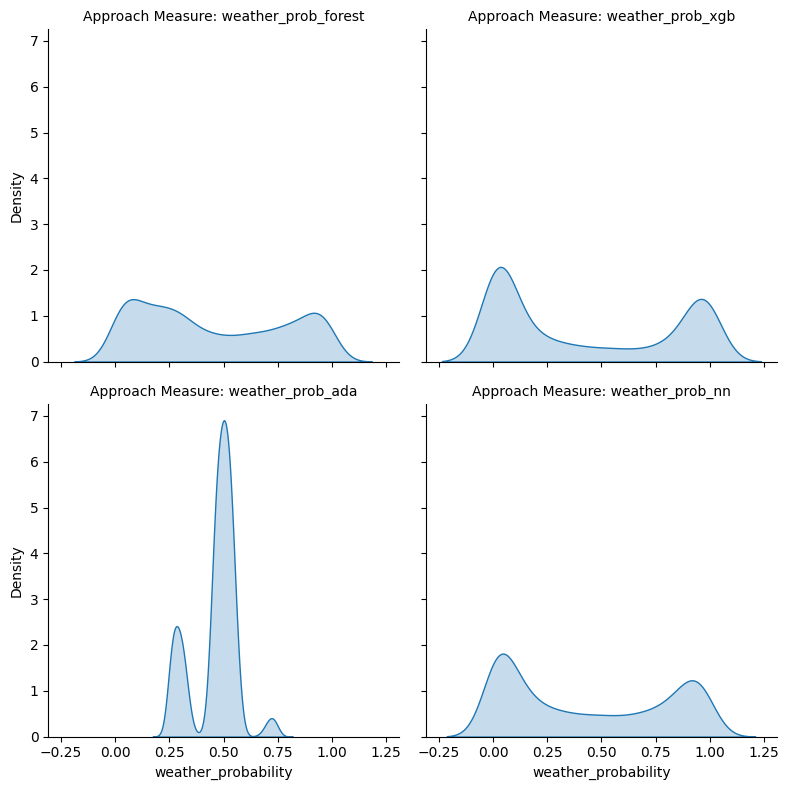

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

gmw = sns.FacetGrid(data = graph_liked_songs, col='model_type', col_wrap=2, height=4, aspect=1)
gmw.map(sns.kdeplot, 'weather_probability', fill=True)
gmw.set_titles('Approach Measure: {col_name}')

We can see from the graph above that each model tends to slightly classify more rainy songs than sunny songs. THis could be because we trained our models with training data that had slightly more rainy songs, or because my liked songs just have more rain-appropriate music. We see that the standard deviation of the adaboost model is much smaller than the other models. In the future, I would like to try to standard scale these values or implement isotonic regression on the adaboost results, but for this initial approach we can just use a different model.

In [ ]:
sun_songs_test = liked_songs.query("weather_prob_xgb > .95").sample(20)

sun_songs_test = MV.add_song_features(sun_songs_test)

Here we get a random sample of 20 of our sunniest songs:

In [ ]:
sun_songs_test

,track.uri,track.id,track.name,track.popularity,danceability_x,energy_x,key_x,loudness_x,mode_x,speechiness_x,...,liveness_y,valence_y,tempo_y,type,id,uri,track_href,analysis_url,duration_ms_y,time_signature_y
0,spotify:track:1fBl642IhJOE5U319Gy2Go,1fBl642IhJOE5U319Gy2Go,Animal,72,0.482,0.833,5,-5.611,1,0.0449,...,0.3650,0.740,148.039,audio_features,1fBl642IhJOE5U319Gy2Go,spotify:track:1fBl642IhJOE5U319Gy2Go,https://api.spotify.com/v1/tracks/1fBl642IhJOE...,https://api.spotify.com/v1/audio-analysis/1fBl...,212293,4
1,spotify:track:5e0dZqrrTaoj6AIL7VjnBM,5e0dZqrrTaoj6AIL7VjnBM,Written in the Stars (feat. Eric Turner),48,0.619,0.971,7,-3.045,1,0.1300,...,0.1960,0.295,122.552,audio_features,5e0dZqrrTaoj6AIL7VjnBM,spotify:track:5e0dZqrrTaoj6AIL7VjnBM,https://api.spotify.com/v1/tracks/5e0dZqrrTaoj...,https://api.spotify.com/v1/audio-analysis/5e0d...,207600,5
2,spotify:track:2c8sgbZoEanC3QyFNZxUcA,2c8sgbZoEanC3QyFNZxUcA,Flexicution,63,0.782,0.713,0,-6.576,0,0.0899,...,0.1080,0.680,159.839,audio_features,2c8sgbZoEanC3QyFNZxUcA,spotify:track:2c8sgbZoEanC3QyFNZxUcA,https://api.spotify.com/v1/tracks/2c8sgbZoEanC...,https://api.spotify.com/v1/audio-analysis/2c8s...,218947,4
3,spotify:track:5RxiYD50AlzGAINxxFoBN2,5RxiYD50AlzGAINxxFoBN2,Uptown Folks,61,0.475,0.824,11,-4.935,0,0.0395,...,0.1360,0.408,117.239,audio_features,5RxiYD50AlzGAINxxFoBN2,spotify:track:5RxiYD50AlzGAINxxFoBN2,https://api.spotify.com/v1/tracks/5RxiYD50AlzG...,https://api.spotify.com/v1/audio-analysis/5Rxi...,288014,4
4,spotify:track:7x6hO9VMAee9x1iWaeNkL6,7x6hO9VMAee9x1iWaeNkL6,To Zion (feat. Carlos Santana),64,0.410,0.601,7,-10.714,1,0.5040,...,0.1120,0.516,173.273,audio_features,7x6hO9VMAee9x1iWaeNkL6,spotify:track:7x6hO9VMAee9x1iWaeNkL6,https://api.spotify.com/v1/tracks/7x6hO9VMAee9...,https://api.spotify.com/v1/audio-analysis/7x6h...,369293,4
5,spotify:track:35Ms8xegBwsiqlz630Io13,35Ms8xegBwsiqlz630Io13,Give a Little Bit,44,0.557,0.951,0,-3.003,1,0.0330,...,0.1570,0.528,93.974,audio_features,35Ms8xegBwsiqlz630Io13,spotify:track:35Ms8xegBwsiqlz630Io13,https://api.spotify.com/v1/tracks/35Ms8xegBwsi...,https://api.spotify.com/v1/audio-analysis/35Ms...,214400,4
6,spotify:track:6Uq65N2DJzKwBj8QBcJ5Xu,6Uq65N2DJzKwBj8QBcJ5Xu,Unforgettable (feat. Swae Lee) - Tiësto vs. Dz...,46,0.668,0.773,1,-6.182,1,0.1160,...,0.1570,0.563,123.975,audio_features,6Uq65N2DJzKwBj8QBcJ5Xu,spotify:track:6Uq65N2DJzKwBj8QBcJ5Xu,https://api.spotify.com/v1/tracks/6Uq65N2DJzKw...,https://api.spotify.com/v1/audio-analysis/6Uq6...,220722,4
7,spotify:track:6YJNcusdf5adRMqJUaRjLt,6YJNcusdf5adRMqJUaRjLt,Horizon,47,0.647,0.761,1,-6.737,0,0.0324,...,0.1490,0.841,124.679,audio_features,6YJNcusdf5adRMqJUaRjLt,spotify:track:6YJNcusdf5adRMqJUaRjLt,https://api.spotify.com/v1/tracks/6YJNcusdf5ad...,https://api.spotify.com/v1/audio-analysis/6YJN...,575120,4
8,spotify:track:3WkibOpDF7cQ5xntM1epyf,3WkibOpDF7cQ5xntM1epyf,It Wasn't Me,81,0.853,0.606,0,-4.596,1,0.0713,...,0.3130,0.654,94.759,audio_features,3WkibOpDF7cQ5xntM1epyf,spotify:track:3WkibOpDF7cQ5xntM1epyf,https://api.spotify.com/v1/tracks/3WkibOpDF7cQ...,https://api.spotify.com/v1/audio-analysis/3Wki...,227600,4
9,spotify:track:2DFRFqWNahKtFD112H2iEZ,2DFRFqWNahKtFD112H2iEZ,Do You Realize??,69,0.464,0.797,0,-5.244,1,0.0333,...,0.3920,0.547,129.964,audio_features,2DFRFqWNahKtFD112H2iEZ,spotify:track:2DFRFqWNahKtFD112H2iEZ,https://api.spotify.com/v1/tracks/2DFRFqWNahKt...,https://api.spotify.com/v1/audio-analysis/2DFR...,213173,4


And here we can use the given spotify recommendations function to add 20 more songs to our playlist. The API recommendations function only allows up to 5 seed tracks at a time, so we iterate through our random sample 5 songs at a time.

In [ ]:
seed_tracks = sun_songs_test['track.id'].tolist()

song_recs = pd.DataFrame()

for i in range(5,len(seed_tracks)+1,5):
    recomms = sp.recommendations(seed_tracks = seed_tracks[i-5:i],
                                 target_acousticness = sun_songs_test['acousticness_x'].mean(),
                                 target_danceability = sun_songs_test['danceability_x'].mean(),
                                 target_energy = sun_songs_test['energy_x'].mean(),
                                 limit = 5)
    tracks = recomms['tracks']
    
    song_recs = pd.concat([song_recs, pd.json_normalize(tracks)])

song_recs[['name', 'uri']]

,name,uri
0,Off She Goes,spotify:track:277XsneDiv30dhONPCOmrF
1,Back Home,spotify:track:07HeFSqsEGq4eWyerDrW1a
2,Honestly,spotify:track:5YhAAlelWek228jZzxgEfr
3,Children of the Sun (feat. John Martin),spotify:track:48KmSSff93Rtn3V7Y4h9kL
4,Who Would’ve Thought,spotify:track:0Lfzhctvqxma6XFZpvcwAD
0,Slow Wind,spotify:track:3Oj7wrQcjXtRQzsin6RxEe
1,Me Love,spotify:track:44M8gY48QHhvc6vn5be10N
2,Bad Habits - MEDUZA Remix,spotify:track:12N23tQKmfGcEO0z8ObwtM
3,Drive,spotify:track:7nnWIPM5hwE3DaUBkvOIpy
4,Wild Ride,spotify:track:7ejxvmmymywiA8O8OeNCLu


## Conclusion

 With this, we can easily create 40 song daily playlists based on the weather! Unfortunately, due to the Spotify API rate limits and reaching the max API calls when working with an almost 4000 song library, I have had to postpone automating the daily playlist creation until the rate limits have reset. 

 However, we can easily use the open weather map API as shown in **weather_api_test.ipynb** to see the daily weather. We can use the field *main* within *weather* with its different options: cloudy, clear, rainy, etc. We can also consider temperature *main.temp* shown in Kelvin. We can partition the classification probability results of the xgboost (or forest, as these were the best performing models) according to match these weather conditions and temperatures, effortlessly making 40 song playlists each day to match the weather. Thanks for checking out this project! Next steps below.

## Next Steps/Explorations:

### Add a scheduled task to generate the weather
    - after fully integrating weather API
    - create playlists every morning based on the forecast for the day!

### Create a Database
    - create a database to easily dump liked song data for ease of retrieval and use
    - postgres database with SQL queries instead of pandas for practice and efficiency

### Automate the pipeline
    - have the data automatically retrieved
    - move beyond just liked songs to more spotify playlists but rate limits :(

### Add more parameters to the Spotify recommender
    - more targeted and appropriate recommendations

### Add to GitHub Pages
    - make the project more presentable!